In [176]:
# Test myanfis model
import myanfis
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy.optimize as opt


In [177]:
param = myanfis.fis_parameters(
    n_input=5,
    n_memb=5,
    batch_size=36,
    memb_func='gbellmf',
    optimizer='adam',
    loss='mse',
    n_epochs=80
)

In [178]:

fis = myanfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='ANFIS-DE'
                    )

In [179]:
# compile model
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss)


In [180]:
# Load dataset from CSV file
data = pd.read_csv("data.csv")


In [181]:
data = data.dropna()

In [182]:
# Variable assignment
X = data[['Glucose', 'INS', 'BMI', 'DPF', 'Age']].values
Y = data['Outcome'].values.reshape(-1, 1)

In [183]:
# Ensure that the number of samples is a multiple of the batch size
X = X[:len(X) // param.batch_size * param.batch_size]
Y = Y[:len(Y) // param.batch_size * param.batch_size]


In [184]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [185]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [186]:
# fit model
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_test, y_test))



Epoch 1/80


8/8 [==============================] - 3s 92ms/step - loss: 0.3105 - val_loss: 0.3276
Epoch 2/80
8/8 [==============================] - 0s 16ms/step - loss: 0.2950 - val_loss: 0.3116
Epoch 3/80
8/8 [==============================] - 0s 15ms/step - loss: 0.2807 - val_loss: 0.2971
Epoch 4/80
8/8 [==============================] - 0s 14ms/step - loss: 0.2684 - val_loss: 0.2834
Epoch 5/80
8/8 [==============================] - 0s 14ms/step - loss: 0.2566 - val_loss: 0.2713
Epoch 6/80
8/8 [==============================] - 0s 13ms/step - loss: 0.2463 - val_loss: 0.2601
Epoch 7/80
8/8 [==============================] - 0s 13ms/step - loss: 0.2366 - val_loss: 0.2502
Epoch 8/80
8/8 [==============================] - 0s 13ms/step - loss: 0.2285 - val_loss: 0.2410
Epoch 9/80
8/8 [==============================] - 0s 14ms/step - loss: 0.2205 - val_loss: 0.2329
Epoch 10/80
8/8 [==============================] - 0s 17ms/step - loss: 0.2136 - val_loss: 0.2255
Epoch 11/80
8/8 [=======================

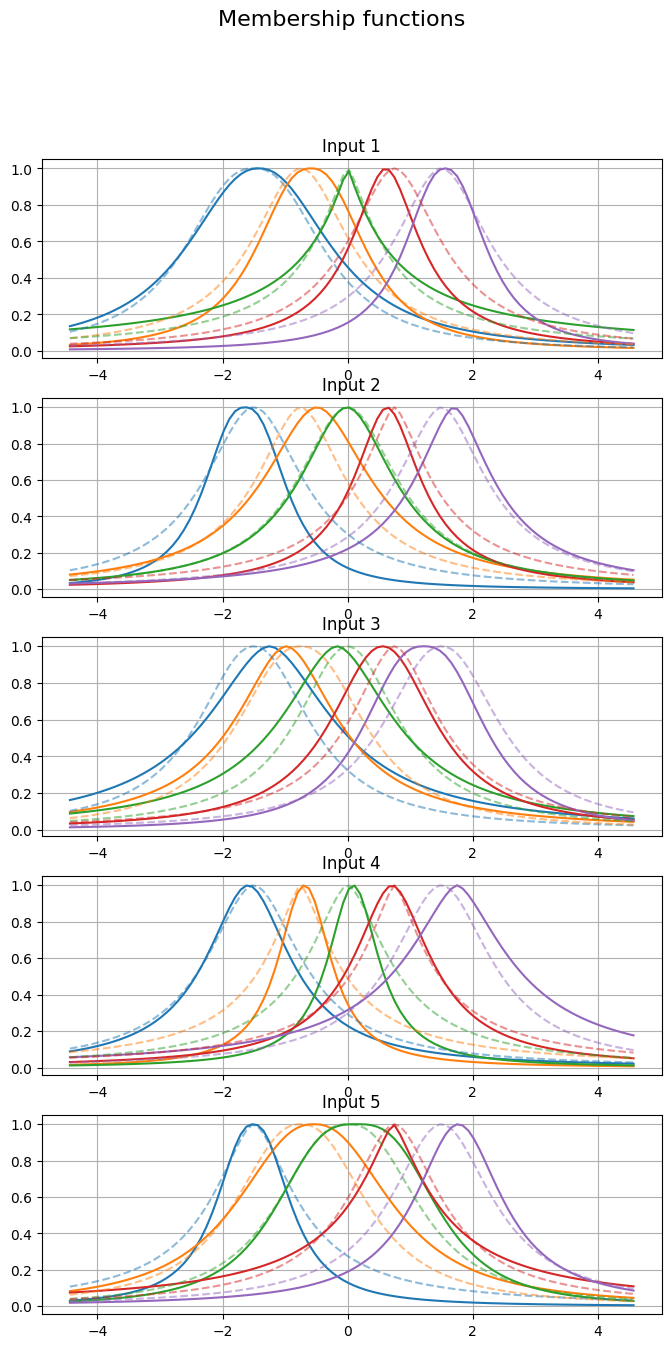

Model: "ANFIS-DE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(36, 5)]                    0         []                            
                                                                                                  
 fuzzyLayer (FuzzyLayer)     (36, 5, 5)                   75        ['inputLayer[0][0]']          
                                                                                                  
 ruleLayer (RuleLayer)       (36, 3125)                   0         ['fuzzyLayer[0][0]']          
                                                                                                  
 normLayer (NormLayer)       (36, 3125)                   0         ['ruleLayer[0][0]']           
                                                                                           

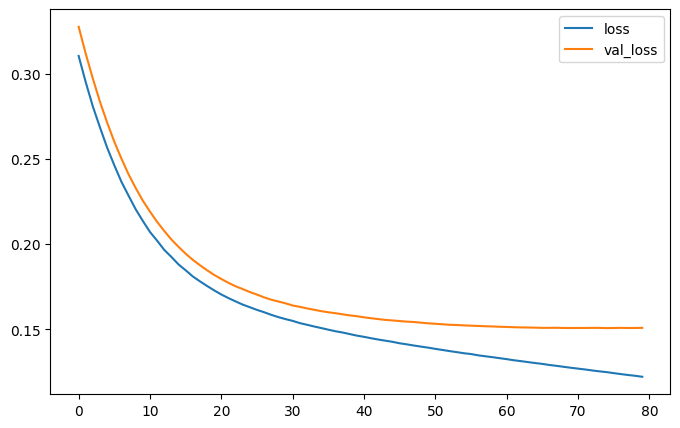

In [187]:
# eval model
fis.plotmfs(show_initial_weights=True)

loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

fis.model.summary()

# get premise parameters
premise_parameters = fis.model.get_layer(
    'fuzzyLayer').get_weights()       # alternative

# get consequence paramters
bias = fis.bias
weights = fis.weights
conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternative


In [188]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Assuming 'y_pred' is the predicted labels and 'y_true' is the true labels
y_pred = fis.__call__(X_test)  # Assuming fis is your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Extract values from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
sensitivity = recall_score(y_test, y_pred_binary)
specificity = tn / (tn + fp)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')


2/2 [==============================] - 0s 6ms/step
Accuracy: 0.7917
Sensitivity (Recall): 0.5200
Specificity: 0.9362
